# Run Test 3.30.23
- 3.25 days (10000*1100, 2^24, 660MHz clock) 
- switch antenna and term (on switch) 
- 13dB fixed attenuation, pasternack 1012 to mini circuits zkl1r5+ (9V regulated from battery). 
- Run started 6:35pm 3.30.23. 
- About 9dB below clipping -> 10^(9/5) = 63 
- 3.25 days * 63 = 204days or 102 days spur performance on terminator 

In [39]:
import sys 
import numpy as np
import settings_runTest_3_30_23 as s
import matplotlib.pyplot as plt 
import importlib
importlib.reload(s)
from cupyx.profiler import benchmark
import h5py
import os
import re
import time
import datetime
from datetime import datetime
import pandas as pd

sys.path.insert(0, '../../../drlib')
import drlib as dr
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

dataDir         = '/drBiggerBoy/runTest_3_30_23/'

totalAcqs       = int(open(s.SAVE_DIRECTORY + 'database.txt', 'r'
                    ).readlines()[-1].split(',')[0].strip()) + 1 

print(totalAcqs)
    



1100


In [ ]:
#time delta analysis
datetimes_str = np.loadtxt(f'{dataDir}database.txt',
                        skiprows=1,
                        usecols=1,
                        delimiter=',',
                        dtype=str)
datetimes =[]
for date in datetimes_str:
    data = date[10]
    datetimes.append(datetime.strptime(date, ' %Y-%m-%d %H:%M:%S.%f'))


diff = []
for i in range(len(datetimes)-1):
    diff.append((datetimes[i+1] - datetimes[i]).total_seconds())

print(f"diff mean:              {np.mean(diff)}")
print(f"diff median:            {np.median(diff)}")
print(f"diff STD:               {np.std(diff)}")
print(f"diff percent error:     {np.std(diff)/np.mean(diff) * 100}")
print(f"expected single time:   {2**24/s.SAMPLE_RATE * 250}")
print(f"total time:             {(datetimes[-1] - datetimes[0]).total_seconds()}")
print(f"expected total time:    {2**24/s.SAMPLE_RATE * s.NOF_BUFFERS_TO_RECEIVE * s.NOF_ACQUISITIONS_TO_TAKE}")

plt.close('all')
plt.figure()
plt.plot(datetimes[1:], diff)
plt.xlabel('Acquisition Index')
plt.ylabel('Time Delta (Seconds)')

In [ ]:
#pack pre proc dataset

try:
    f.close()
    print("closed")
except:
    print("didn't close")
    pass

rawDataDir      = dataDir + 'data/'
fileList        = os.listdir(rawDataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))
newDataDir      = dataDir
fileName        = 'packedh5.hdf5'
if 0: #will overwrite!!!

    f               = h5py.File(newDataDir + fileName, 'w')

    #init empty dataset
    print(f'initilizing dataset 8388609x{totalAcqs}')
    spec_W    = f.create_dataset('spec_W_chB', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    print(spec_W)

    ##############################################################
    #Main loop
    ##############################################################
    numFiles        = 0
    numMeasData     = 0
    numRigolSpec    = 0

    compType = False
    chunks = None #must add chunks arg to create dataset calls

    for fileidx, file in enumerate(fileList):
        if fileidx % 10 == 0:
            print(file)
        dataset         = h5py.File(rawDataDir +  file, 'r')
        numFiles        += 1
        measDataKeys    = list(dataset.keys())
        measDataKeys.sort(key=lambda f: int(re.sub('\D', '', f)))
        #measDataKeys = [int(key) for key in measDataKeys]

        for measData in measDataKeys:
            measDataInt = int(measData)
            '''Dumb check. Is the date in raw h5 measData the same as what
            the database thinks it is? Since we previously check that dates
            are consectutive this also checks that dates 
            in raw h5 are consecutive'''
            '''datasetDf   = pd.read_hdf(rawDataDir + file, key = measData)#raw H5 
            dateTimeStr = datasetDf.columns[0][0]#datetime extracted from raw H5
            dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')'''

            '''Check database at a measData has the same datetime as we are about
            to load into new h5'''
            '''if not (dateTime==database[database['measData'] == measDataInt].index):
                print('Dates got jumbled at measData', measDataInt)'''

            spec_W_np        = np.float32(dataset[measData]['chBSpec_W'])
            #print(measData)
            #termSpec    = np.float32(dr.fft2Watts(datasetDf.iloc[:,0][:]))
            #diffSpec    = np.float32((antSpec-termSpec))

            spec_W[:, measDataInt]    = spec_W_np

f.close()

In [41]:
#pack pre proc veto dataset

try:
    f.close()
    print("closed")
except:
    print("didn't close")
    pass

rawDataDir      = dataDir + 'data/'
fileList        = os.listdir(rawDataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))
newDataDir      = dataDir
fileName        = 'packedh5.hdf5'
if 0: #will overwrite!!!

    f               = h5py.File(newDataDir + fileName, 'a')

    #init empty dataset
    print(f'initilizing dataset 8388609x{totalAcqs}')
    spec_W    = f.create_dataset('spec_W_chA', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    print(spec_W)

    ##############################################################
    #Main loop
    ##############################################################
    numFiles        = 0
    numMeasData     = 0
    numRigolSpec    = 0

    compType = False
    chunks = None #must add chunks arg to create dataset calls

    for fileidx, file in enumerate(fileList):
        if fileidx % 10 == 0:
            print(file)
        dataset         = h5py.File(rawDataDir +  file, 'r')
        numFiles        += 1
        measDataKeys    = list(dataset.keys())
        measDataKeys.sort(key=lambda f: int(re.sub('\D', '', f)))
        #measDataKeys = [int(key) for key in measDataKeys]

        for measData in measDataKeys:
            measDataInt = int(measData)
            '''Dumb check. Is the date in raw h5 measData the same as what
            the database thinks it is? Since we previously check that dates
            are consectutive this also checks that dates 
            in raw h5 are consecutive'''
            '''datasetDf   = pd.read_hdf(rawDataDir + file, key = measData)#raw H5 
            dateTimeStr = datasetDf.columns[0][0]#datetime extracted from raw H5
            dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')'''

            '''Check database at a measData has the same datetime as we are about
            to load into new h5'''
            '''if not (dateTime==database[database['measData'] == measDataInt].index):
                print('Dates got jumbled at measData', measDataInt)'''

            spec_W_np        = np.float32(dataset[measData]['chASpec_W'])
            #print(measData)
            #termSpec    = np.float32(dr.fft2Watts(datasetDf.iloc[:,0][:]))
            #diffSpec    = np.float32((antSpec-termSpec))

            spec_W[:, measDataInt]    = spec_W_np

f.close()

didn't close
initilizing dataset 8388609x1100
<HDF5 dataset "spec_W_chA": shape (8388609, 1100), type "<f4">
0.hdf5
10.hdf5
20.hdf5
30.hdf5
40.hdf5
50.hdf5
60.hdf5


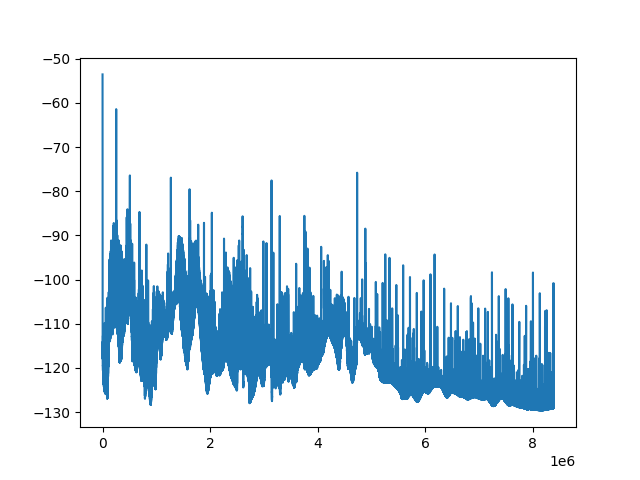

In [49]:
f               = h5py.File(newDataDir + fileName, 'r')
vetoSpec = f['spec_W_chA'][:,0]
f.close()

plt.close('all')
plt.figure()
plt.plot(10*np.log10(vetoSpec*1000))


In [ ]:
#Average and save spectra

#location of packed h5
fileName        = 'packedh5.hdf5'


f               = h5py.File(dataDir + fileName, 'r')

def avgSpecFromPacked(avgIdxs):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f['spec_W_chB'][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec

def rollingMadLim(spec,
    nSigma = 1,
    order = 1,
    fc_numBins = 100
):
    specFiltered = dr.filterSpec(spec, fc_numBins=fc_numBins, order=order)
    window = 1000

    rollingMadArr = dr.rolling(specFiltered, window, 1, mad_np, numProc=48)

    filter_fc           = 30 * window
    filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
    diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
    rollMadLim      = diffFilterMadPadArr * nSigma * 1.48
    return rollMadLim, specFiltered, nSigma, order, fc_numBins

#Average, filter and save
if 0:
    antIdxs     = range(0, totalAcqs-1, 2)[0:-1]
    termIdxs    = range(1, totalAcqs-1, 2)
    avgAntSpec  = avgSpecFromPacked(antIdxs)
    avgtermSpec = avgSpecFromPacked(termIdxs)

    np.save('./avgSpecs_gitignore/avgAntSpec_W_11e6FFTs_3_30_23', avgAntSpec)
    np.save('./avgSpecs_gitignore/avgTermSpec_W_11e6FFTs_3_30_23', avgtermSpec)
    print('Done saving raw spectra')

    #filter/rolling mad limit and save
    antRollingMadLim, antFilt, Sigma, order, fc_numBins     = rollingMadLim(avgAntSpec)
    termRollingMadLim, termFilt, nSigma, order, fc_numBins   = rollingMadLim(avgtermSpec)

    np.save(f'./avgSpecs_gitignore/antRollingMadLim_W_11e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_30_23', antRollingMadLim)
    np.save(f'./avgSpecs_gitignore/termRollingMadLim_W_11e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_30_23', termRollingMadLim)
    np.save(f'./avgSpecs_gitignore/antFilt_W_11e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_30_23', antFilt)
    np.save(f'./avgSpecs_gitignore/termFilt_W_11e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_30_23', termFilt)

    f.close()


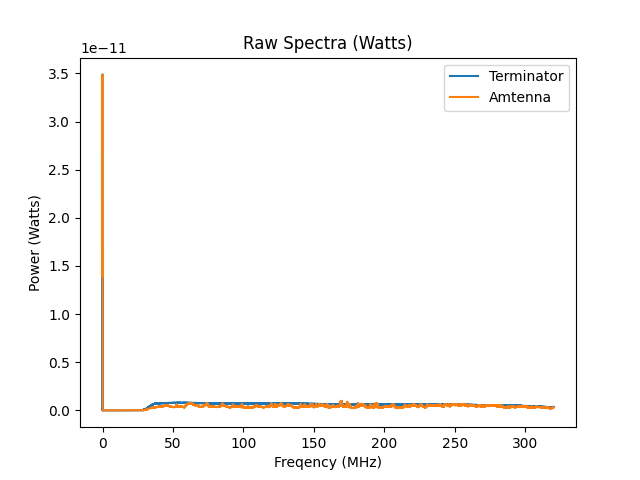

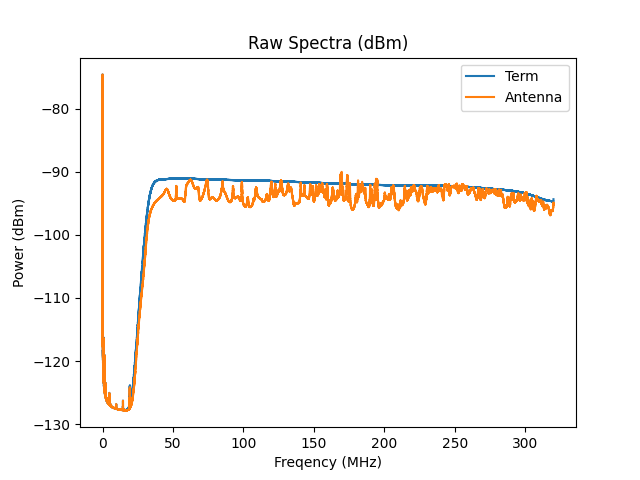

In [38]:
#load files generated in previous cell
nSigma      = 6
order       = 1
fc_numBins  = 100

avgAntSpec          = np.load('./avgSpecs_gitignore/avgAntSpec_W_11e6FFTs_3_30_23.npy', allow_pickle=True)
avgTermSpec         = np.load('./avgSpecs_gitignore/avgTermSpec_W_11e6FFTs_3_30_23.npy', allow_pickle=True)

filtAntSpec         = np.load(f'./avgSpecs_gitignore/antFilt_W_11e6FFTs_nSigma1_order{order}_fc{fc_numBins}_3_30_23.npy', 
    allow_pickle=True
)
filtTermSpec        = np.load(f'./avgSpecs_gitignore/termFilt_W_11e6FFTs_nSigma1_order{order}_fc{fc_numBins}_3_30_23.npy', 
    allow_pickle=True
)
termRollingMadLim   = nSigma * np.load(f'./avgSpecs_gitignore/termRollingMadLim_W_11e6FFTs_nSigma1_order{order}_fc{fc_numBins}_3_30_23.npy',
    allow_pickle=True
)
antRollingMadLim   = nSigma * np.load(f'./avgSpecs_gitignore/antRollingMadLim_W_11e6FFTs_nSigma1_order{order}_fc{fc_numBins}_3_30_23.npy',
    allow_pickle=True
)


#plot raw spectra
freqs       = np.linspace(0, 320, 2**23)

plt.close('all')

plt.title('Raw Spectra (Watts)')
plt.plot(freqs, avgTermSpec[1:], label = 'Terminator')
plt.plot(freqs, avgAntSpec[1:], label = 'Amtenna')
plt.ylabel('Power (Watts)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')

plt.figure()
plt.title('Raw Spectra (dBm)')
plt.plot(freqs, 10*np.log10(avgTermSpec[1:]*1000), label = 'Term')
plt.plot(freqs, 10*np.log10(avgAntSpec[1:]*1000), label = 'Antenna')
plt.ylabel('Power (dBm)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')


nSigma: 6
225 antenna candidates
4 term candidates


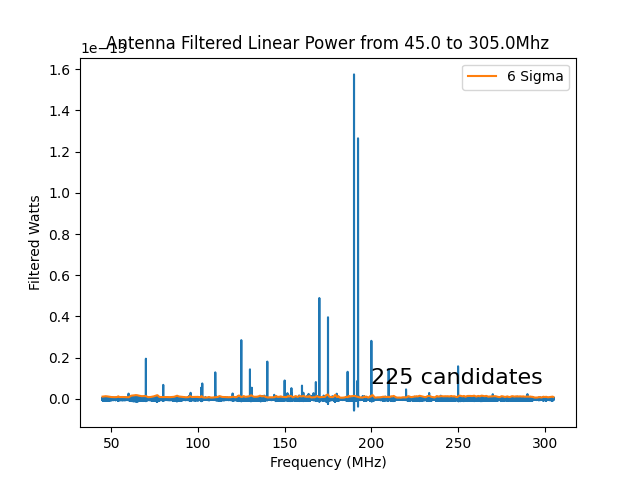

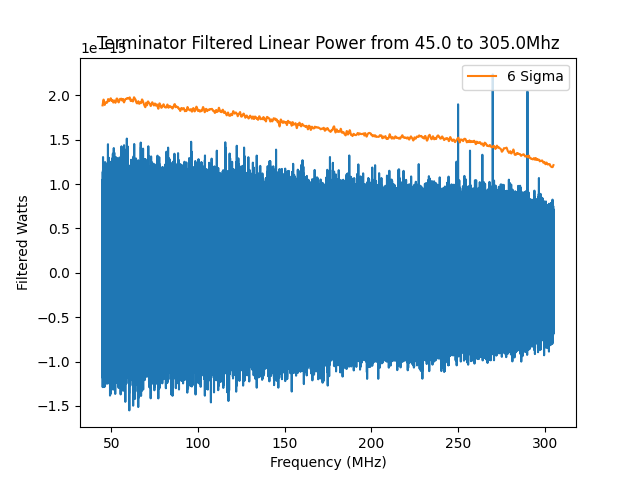

In [20]:
print(f'nSigma: {nSigma}')

pltFreqStart = 45e6
pltFreqStop = 305e6
freqs=np.linspace(0,660e6/2, 2**23)
pltIdxStart = freq2Idx(pltFreqStart, freqs)
pltIdxStop = freq2Idx(pltFreqStop, freqs)

antCanList_idx = ((filtAntSpec > antRollingMadLim)) 
antCandidateTotal = (antCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{antCandidateTotal} antenna candidates")

termCanList_idx = ((filtTermSpec > termRollingMadLim)) 
termCandidateTotal = (termCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{termCandidateTotal} term candidates")


plt.close('all')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtAntSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(antRollingMadLim)[pltIdxStart:pltIdxStop], label = f'{nSigma} Sigma')
plt.text(200,.75e-14, f'{antCandidateTotal} candidates',size=16)
plt.title(f"Antenna Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')
plt.legend(loc='upper right')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(termRollingMadLim)[pltIdxStart:pltIdxStop],label = f'{nSigma} Sigma')
plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
plt.title(f"Terminator Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')
plt.legend(loc='upper right')

if 0:
    plt.figure()
    plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtAntSpec[pltIdxStart:pltIdxStop], label = 'Antenna')
    plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop], label = 'Terminator', alpha = .5)
    plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
    plt.title(f"Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Filtered Watts')
    plt.legend(loc = 'upper right')

In [21]:
#generate lists of candidates

antCanIdx   = (np.where(antCanList_idx  == True))[0]
termCanIdx  = (np.where(termCanList_idx == True))[0]

antMask     = (antCanIdx >= pltIdxStart) & (antCanIdx <= pltIdxStop)
termMask    = (termCanIdx >= pltIdxStart) & (termCanIdx <= pltIdxStop)

antCanIdx   = antCanIdx[antMask]
termCanIdx  = termCanIdx[termMask]

antCanFreqs =np.asarray([idx2freq(idx,freqs) for idx in antCanIdx])
termCanFreqs=np.asarray([idx2freq(idx,freqs) for idx in termCanIdx])



print(len(antCanFreqs), 'antenna candidates')
#print('at freqs. ', antCanFreqs/1e6)
print(len(termCanFreqs), 'terminator candidates')
print('at freqs. ', termCanFreqs/1e6)

225 antenna candidates
4 terminator candidates
at freqs.  [249.99948621 269.99950647 289.99952674 290.00043154]


In [26]:
def consolidateCandidates(rawCanList, freqs, stepsize=1):
    '''
    Takes array of indices of candidates and returns a data frame
    with one row per candidate and columns with the candidate frequency,
    number of bins wide and the starting index of that candidate
    Inputs:
        rawCanList (1D list or np array): list of indices of candidates
        reqs (1D list or np array): list of frequencies
        stepsize: should be 1 to find adjecent candidates
    Calls:
        idx2Freq()
    '''
    rawCanList = np.asarray(rawCanList)
    splitList =  np.split(rawCanList, np.where(np.diff(rawCanList) > stepsize)[0]+1)
    canList = [can[0] for can in splitList]
    canListFreq =  [idx2freq(can[0],freqs) for can in splitList]
    canLenList = [len(can) for can in splitList]
    candidate_df = pd.DataFrame()
    candidate_df['canFreq_Mhz'] = [freq/1e6 for freq in canListFreq]
    candidate_df['numBins'] = canLenList
    candidate_df['idx'] = canList
    #candidate_df['idx absolute'] = [idx + idxStart for idx in canList]
    diffArr = np.zeros(len(canList))
    diffArr[0] =  float('nan')
    diffArr[1:] = np.diff(canList)
    candidate_df['deltaIdx'] = diffArr
    candidate_df['deltaFreq_Hz'] = [deltaIdx* (s.SAMPLE_RATE) /s.CH0_RECORD_LEN for deltaIdx in diffArr]

    return candidate_df

stepsize = 10
candidate_df = consolidateCandidates(antCanIdx, freqs, stepsize=stepsize)
candidate_df.to_csv(f'candidateListCsvs/candidateList_diffGreaterThan10Bins_{nSigma}sigma_fc100bins_Order1_4_3_23.csv')
candidate_df

,canFreq_Mhz,numBins,idx,deltaIdx,deltaFreq_Hz
0,59.999982,2,1525201,NaN,NaN
1,69.999973,2,1779401,254200.0,9.999990e+06
2,80.000002,1,2033602,254201.0,1.000003e+07
3,94.424379,1,2400270,366668.0,1.442438e+07
4,95.187714,1,2419674,19404.0,7.633352e+05
...,...,...,...,...,...
176,250.000863,1,6355028,254205.0,1.000019e+07
177,269.999506,1,6863394,508366.0,1.999864e+07
178,270.000451,1,6863418,24.0,9.441376e+02
179,289.999527,1,7371795,508377.0,1.999908e+07


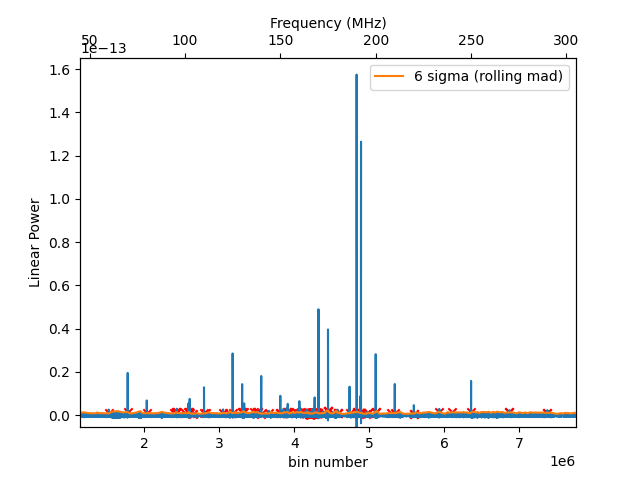

stepsize = 10 
butter filter (order = 1 and f_c = 100 bins)
number of candidates =  181


In [37]:

fig, ax = plt.subplots()

ax.plot(np.arange(0, len(freqs), 1), np.zeros(len(freqs)), alpha = 0)
ax.set_xlabel('bin number')
ax.xaxis.tick_top()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_ticks_position('top')
ax.set_xlim(pltIdxStart, pltIdxStop)
ax.set_ylim(np.min(filtAntSpec[pltIdxStart:pltIdxStop]), 
    np.max(filtAntSpec[pltIdxStart:pltIdxStop]*1.05)
)
ax.set_ylabel('Linear Power')

ax2 = ax.twiny()

ax2.plot(freqs/1e6, filtAntSpec[1:])
ax2.plot(freqs/1e6,  antRollingMadLim[1:], label = f'{nSigma} sigma (rolling mad)')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Linear Power (W)')


#ax2.plot(np.arange(pltIdxStart, pltIdxStop, 1), antRollingMadLim[pltIdxStart:pltIdxStop], 'orange', label = '5 sigma (rolling mad)')
ax2.scatter(freqs[candidate_df['idx']]/1e6, antRollingMadLim[candidate_df['idx']], color ='r', marker = 'x')
ax2.set_xlim(pltFreqStart/1e6, pltFreqStop/1e6)
#ax2.set_ylim(np.min(filtAntSpec[pltIdxStart:pltIdxStop]), 
#    np.max(filtAntSpec[pltIdxStart:pltIdxStop])
#)

ax2.legend(loc = 'upper right')
ax2.xaxis.tick_top()

plt.show()

print('stepsize = %i ' %stepsize)
print('butter filter (order = %i and' %order, 'f_c = %i'  %fc_numBins, 'bins)')

print('number of candidates = ', len(candidate_df['idx']) )

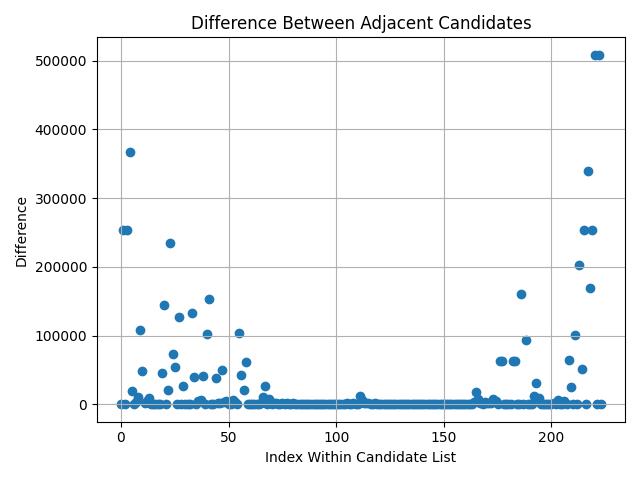

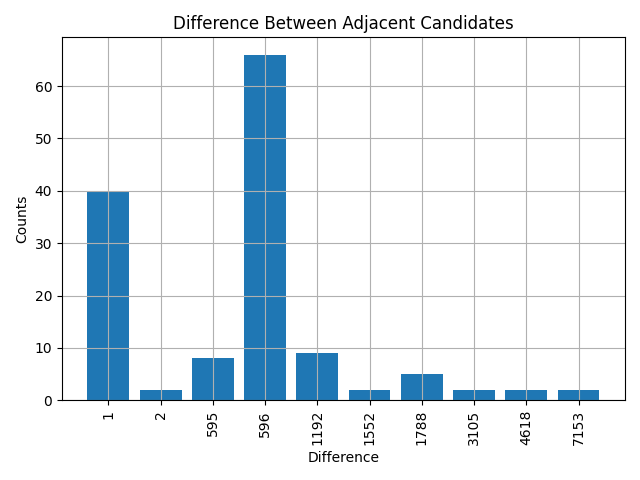

In [36]:
#create a list of bunches of spurs
print()
idxDiff = np.diff(antCanIdx)
#print(idxDiff)
diffMask = np.where(idxDiff == 1, True, False)
diffMask = np.append(False, diffMask,)

onesIdxs = antCanIdx[diffMask]
#print(freqs[onesIdxs])

hist, binEdges = np.histogram(idxDiff, bins = 10000, range=(1,10001))
#print(binEdges)
histNoZeros = []
binsNoZeros = []
for i, val in enumerate(hist):
    if val != 0 and val != 1:
        histNoZeros.append(val)
        binsNoZeros.append(binEdges[i])
binsNoZeros =[str(int(bin)) for bin in binsNoZeros]

plt.close('all')
plt.figure()
#plt.semilogy()
plt.scatter(np.arange(0, len(idxDiff), 1),(idxDiff))
plt.title('Difference Between Adjacent Candidates')
plt.xlabel('Index Within Candidate List')
plt.ylabel('Difference')
plt.grid()
plt.tight_layout()

#hist without skipping empty bins. Not useful
if 0:
    plt.figure();
    plt.hist(idxDiff, bins = 10000, range=(2,10002));
    plt.title('Difference Between Adjacent Candidates')
    plt.xlabel('Difference')
    plt.ylabel('Counts')

#hist skipping unused bins
plt.figure();
plt.bar(binsNoZeros, histNoZeros);
plt.title('Difference Between Adjacent Candidates');
plt.xlabel('Difference');
plt.ylabel('Counts');
plt.xticks(rotation='vertical');
plt.tight_layout()
plt.grid()